## Tag and probe

So far, we've computed all our efficiencies using ground truth as provided by our simulation to categorize our signal and background reconstructed electrons.  If we trust our simulation to perfectly describe the detector response, then our job is done.  We cannot do that (**Q: why might we need to know true electron tagging efficiency in data?**), so we need to measure the efficiency in data, categorizing signal and background by inference.  How do we do this without selection bias?  Thanks to the Z boson, we have a solution: tag one electron in an event that passes some high quality requirement, then look for a "probe" electron such that the invariant mass of the di-electron pair ($m_{ee}$) matches that of the Z boson.  If we count the number of probes falling in some mass window that pass and fail our ID, we can infer the true electron tagging efficiency in data, despite not knowing the ground truth for each electron.
Below is a basic example of making a tag and probe selection, then plotting the pass and fail mass distributions, for POG cut-based electron ID, using our simulated Z event sample.

In [1]:
import uproot
from glob import glob
base_directory = '/eos/user/c/cmsdas/2023/short-ex-egamma/datasets/'
dyfiles = sorted(glob(f'{base_directory}/DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8/*.root'))
gjetfiles = sorted(glob(f'{base_directory}/GJets_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8/*.root'))
datafiles = sorted(glob(f'{base_directory}/EGamma-Run2018A/*.root'))
file = uproot.open(dyfiles[0])
dict(file)

{'tag;1': <TObjString 'untagged' at 0x7f689c8dcf20>,
 'Events;1': <TTree 'Events' (1628 branches) at 0x7f689c87ea00>,
 'LuminosityBlocks;1': <TTree 'LuminosityBlocks' (2 branches) at 0x7f689c87e8b0>,
 'Runs;1': <TTree 'Runs' (8 branches) at 0x7f689c87e1f0>,
 'MetaData;1': <TTree 'MetaData' (1 branches) at 0x7f689c87e310>,
 'ParameterSets;1': <TTree 'ParameterSets' (1 branches) at 0x7f688a664430>}

In [2]:
from coffea.nanoevents import NanoEventsFactory

dyevents = NanoEventsFactory.from_root(dyfiles[0]).events()
gevents = NanoEventsFactory.from_root(gjetfiles[0]).events()
dataevents = NanoEventsFactory.from_root(datafiles[0]).events()

In [5]:
import awkward as ak
zcands = ak.combinations(dyevents.Electron, 2, fields = ["tag", "probe"])
# filter pairs to have a good tag
zcands = zcands[
    (zcands.tag.pt > 20.)
    & (abs(zcands.tag.eta) < 2.1)
    & (zcands.tag.cutBased >= zcands.tag.TIGHT)
    & (zcands.probe.pt > 10.)
]
# filter out events that have no z candidates
zcands = zcands[ak.num(zcands) > 0]
# some events may have multiple candidates, take the one with highest pt (i.e. the default ordering in NanoAOD)
zcands = ak.firsts(zcands)
# compute invariant mass
mass = (zcands.tag + zcands.probe).mass

goodprobe = zcands.probe.cutBased >= zcands.probe.LOOSE

Text(0.5, 0, 'Dielectron mass [GeV]')

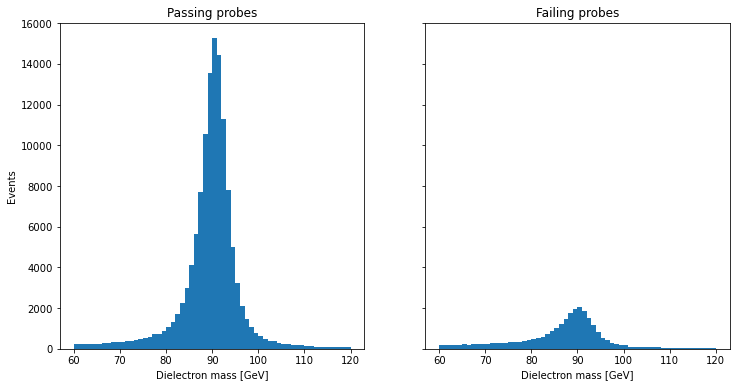

In [8]:
import matplotlib.pyplot as plt
import numpy as np
fig, (axp, axf) = plt.subplots(1, 2, sharey = True, figsize = (12, 6))
mbins = np.linspace(60, 120, 61)

axp.hist(mass[goodprobe], bins = mbins)
axp.set_title('Passing probes')
axp.set_ylabel('Events')
axp.set_xlabel('Dielectron mass [GeV]')

axf.hist(mass[~goodprobe], bins = mbins)
axf.set_title('Failing probes')
axf.set_xlabel('Dielectron mass [GeV]')

Now make the same plot with low and high probe $p_{T}$ requirements.  How does the mass shape and relative peak height change?

**Plot the same distribution for electrons in real data**

Try repeating the exercise above using `dataevents` instead of `dyevents`. You'll notice the failing distribution's peak is hidden under a much larger amount of background. This is combinatorial background from random fake electrons combining with the tag to create a continuous falling invariant mass spectrum. Try applying some selections on the identification variables above, and see how they impact signal and background distributions.

To properly measure the peak height, a full analysis would have to subtract this background by fitting the pass and fail distributions.  If you got this far, try using [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) to fit each distribution.

## Scale Factors

Tag and probe is the main method used derive the efficiencies that serve as inputs to the electron and photon *scale factors* (and most scale factors in general). The scale factors we will be using are defined as the ratio of the data efficieny to the Monte Carlo (MC) efficiency.


Scale factors for electrons and photons are applied as event weights. Scale factors serve to match the MC object efficiency (ID, reconstruction, etc.) to the observed data efficiency. **Q: Why could this correction be needed?**. Scale factors are accessible via [ROOT Histograms](https://twiki.cern.ch/twiki/bin/view/CMS/EgammaUL2016To2018#General_note_about_ID_SFs) and [JSONs](https://twiki.cern.ch/twiki/bin/viewauth/CMS/EgammaSFJSON). The JSON format works particularly well with NanaAOD and Coffea-based analyeses, so we will include a brief example of how to access the electron ID scale factors using the `correctionlib` package.

In [9]:
from correctionlib import CorrectionSet

evaluator = CorrectionSet.from_file("/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/EGM/2018_UL/electron.json.gz")

Now that we have scale factors accessible, we need to apply them to our analysis! We already have a collection of Z candidates built (our tag and probe pairs), so we will use those. Normally you will not apply SFs to a tag and probe analyses, but this is just to serve as an example of how to apply scale factors to a Z candidate. 

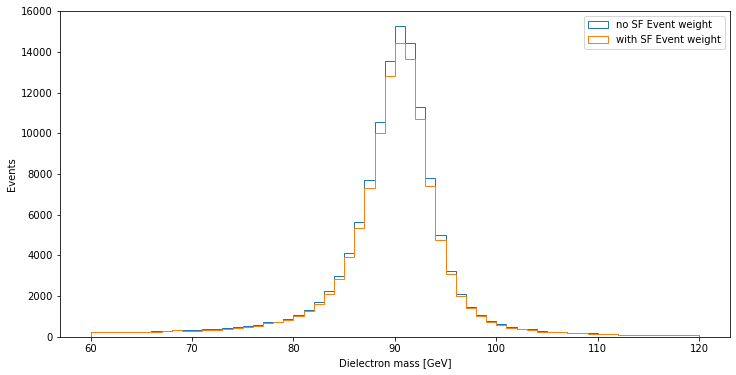

In [10]:
#Get the ID scale factor for each electron in the pair
sfel1 = evaluator["UL-Electron-ID-SF"].evaluate("2018", "sf", "Tight", zcands.tag.eta.to_numpy(), zcands.tag.pt.to_numpy())
sfel2 = evaluator["UL-Electron-ID-SF"].evaluate("2018", "sf", "Loose", zcands.probe.eta.to_numpy(), zcands.probe.pt.to_numpy())

sftot = sfel1 * sfel2

#Apply the weights to the 'Good probes' Z mass peak
fig, ax = plt.subplots(figsize = (12, 6))
mbins = np.linspace(60, 120, 61)

ax.hist(mass[goodprobe], bins = mbins,label="no SF Event weight",histtype='step')
ax.hist(mass[goodprobe], bins = mbins, weights = sftot[goodprobe],label="with SF Event weight",histtype='step')
ax.set_ylabel('Events')
ax.set_xlabel('Dielectron mass [GeV]')
ax.legend()

Very similar! We need a better way to decide if the scale factors are relevant. Plots that directly show the differences between the two, such as ratio plots, may be useful.